<a href="https://www.kaggle.com/code/llkh0a/simple-dem-data-gpt-4o-mini-image-prompt?scriptVersionId=244410884" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In this notebook, I will introduce a simple method to extract DEM data from the OpenTopography API 🌍.

🖼️ Next, we'll use an input image as a prompt to GPT-4o-mini 🤖 for further processing.

📺 For a detailed tutorial on requesting the OpenTopography API, check out this video:
https://www.youtube.com/watch?v=tjnxsQW5mf8 🎥

🔑 To get your OpenAI API key, visit:
https://platform.openai.com/ 🔐

🔐 For security, I’ve using the kaggle secrets for more detail: [user secrets](https://www.kaggle.com/discussions/product-feedback/114053)

In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 77.0 MB/s eta 0:00:00:00:0100:01


In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

In [8]:
import base64
import urllib.request
import io
from PIL import Image
import matplotlib.pyplot as plt
from openai import OpenAI
import numpy as np
import rasterio
import os
from openai import OpenAI
os.environ["OPENAI_API_KEY"] = user_secrets.get_secret("open_ai_key")
OT_api_key=user_secrets.get_secret("OT_api_key")

## Step 1: extract lidar data from OpenTopography API

In [4]:
import requests

def download_lidar_tile(demtype, south, north, west, east, output_file,api_key=OT_api_key):
    """
    Downloads a LiDAR tile from OpenTopography using the specified parameters.
    """
    # Define the OpenTopography API endpoint
    BASE_URL = "https://portal.opentopography.org/API/globaldem"

    # Parameters for the API request
    params = {
        "demtype": demtype,
        "south": south,
        "north": north,
        "west": west,
        "east": east,
        "outputFormat": "GTiff",
        "API_Key": api_key
    }

    # Make the API request
    response = requests.get(BASE_URL, params=params)

    # Check if the request was successful
    if response.status_code == 200:
        # Save the downloaded file
        with open(output_file, "wb") as file:
            file.write(response.content)
        print(f"LiDAR data downloaded successfully: {output_file}")
    else:
        print(f"Failed to download data. Status code: {response.status_code}")
        print("Response:", response.text)

In [5]:
# Example usage of the function
download_lidar_tile(
                    demtype='COP90',
                    south=-4.919116467989866,
                    north=-0.7591338330879864,
                    west=-69.26220683008432,
                    east=-57.18603347986936,
                    output_file='lidar_tile.tif')

LiDAR data downloaded successfully: lidar_tile.tif


you can get the cordinates for the wanted area in https://portal.opentopography.org/datasets

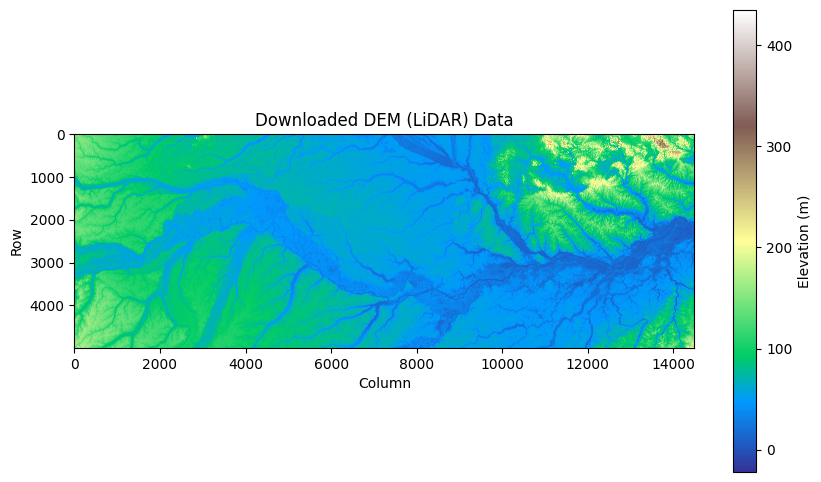

In [10]:
with rasterio.open('lidar_tile.tif') as src:
    dem = src.read(1)
    plt.figure(figsize=(10, 6))
    plt.imshow(dem, cmap='terrain')
    plt.colorbar(label='Elevation (m)')
    plt.title('Downloaded DEM (LiDAR) Data')
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.show()
    # Step 2: Save the plot to a BytesIO buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='JPEG', bbox_inches='tight')
    plt.close()  # Close the plot to free memory
    buf.seek(0)


In [21]:
# Load DEM data
with rasterio.open('lidar_tile.tif') as src:
    dem = src.read(1)
    dem = np.where(dem == src.nodata, np.nan, dem)  # Mask nodata if any

# Normalize for visualization
vmin = np.nanpercentile(dem, 2)
vmax = np.nanpercentile(dem, 98)

# Plot with better visibility
plt.figure(figsize=(10, 6))
plt.imshow(dem, cmap='terrain', vmin=vmin, vmax=vmax)
plt.axis('off')  # Remove axis for cleaner image
plt.tight_layout()

# Save plot to buffer
buf = io.BytesIO()
plt.savefig(buf, format='jpeg', bbox_inches='tight', dpi=150)
plt.close()
buf.seek(0)

# Convert to base64
img_base64 = base64.b64encode(buf.getvalue()).decode('utf-8')

## Step 2: Use OpenAI Model to Describe Surface Features



In [22]:
client = OpenAI()
CHOSEN_MODEL = "gpt-4.1"

prompt = "Analyze this Digital Elevation Model (DEM) image and describe the terrain and surface features in plain English. Identify features such as valleys, rivers, mountains, flatlands, and changes in elevation.."

response = client.chat.completions.create(
    model=CHOSEN_MODEL,
    messages=[
        {"role": "user", "content": prompt},
        {
            "role": "user",
            "content": [
                
                    {"type": "text", "text": prompt},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"}}
                
            ]
        }
    ]
)

print(response.choices[0].message.content)


Certainly! Here’s a plain English analysis of the terrain and surface features shown in the DEM (Digital Elevation Model) image:

---

**General Terrain:**

- **Color Coding**: The image uses a color gradient to indicate elevation:
  - **Brown/White** areas = **Higher elevations** (mountains, hills)
  - **Yellow/Green** areas = **Moderate to low elevations** (flatlands, valleys)
  - **Blue/Dark Blue** areas = **Lowest elevations** (river valleys, floodplains)

---

**Key Features:**

### 1. **Mountains & High Elevations**
- The **top right and left corners**, and part of the left edge, are mostly brown and some white, indicating these are mountainous regions with high terrain.
- The white patches in the top right suggest the highest peaks, possibly snow-covered.

### 2. **Valleys**
- Numerous **branching lines** run from the mountain areas toward the center and lower parts of the image. These indicate valleys carved by rivers and streams.
- These valleys broaden as they move away from 